# AOS makeGainImages.py like BOT calibs...

Make calib images structured in the same way as the BOT calibs so that ISR can be performed :

In [1]:
import glob
import os
from astropy.table import Table
import numpy as np
import astropy.io.fits as fits

# From Pinholes-gen2.ipynb

path_to_calibs = '/project/shared/BOT/rerun/rhl/CALIB-6813D/bias/2019-10-18/'



In [4]:
calibs = os.listdir(path_to_calibs)

Ok, there are bias images for BOT files. What's the header structure ? 

In [11]:
path_to_file = os.path.join(path_to_calibs, calibs[0])
hdu = fits.open(path_to_file)

In [9]:
path_to_file

'/project/shared/BOT/rerun/rhl/CALIB-6813D/bias/2019-10-18/bias-R22-S11-det094_2019-10-18.fits'

In [13]:
hdu[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
RUNNUM  = '6813D   '           / The Run Number                                 
TSTAND  = 'BOT     '           / Camera test stand BOT or CCOB                  
INSTRUME= 'lsstCam '           / Instrument                                     
CONTNUM = '18ee3eaa'           / REB serial # (Hex)                             
SEQFILE = 'FP_E2V_2s_ir2_v2.seq' / Sequencer file name                          
CCDSLOT = 'S11     '           / The CCD Slot                                   
RAFTBAY = 'R22     '        

In [14]:
hdu[1].header

XTENSION= 'IMAGE   '           / binary table extension                         
BITPIX  =                  -32 / data type of original image                    
NAXIS   =                    2 / dimension of original image                    
NAXIS1  =                 4608 / length of original image axis                  
NAXIS2  =                 4096 / length of original image axis                  
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
LTV1    =                   0.                                                  
LTV2    =                   0.                                                  
INHERIT =                    T                                                  
EXTTYPE = 'IMAGE   '                                                            
CTYPE1A = 'LINEAR  '           / Type of projection                             
CTYPE2A = 'LINEAR  '        

In [15]:
hdu[2].header

XTENSION= 'IMAGE   '           / binary table extension                         
BITPIX  =                   32 / data type of original image                    
NAXIS   =                    2 / dimension of original image                    
NAXIS1  =                 4608 / length of original image axis                  
NAXIS2  =                 4096 / length of original image axis                  
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
LTV1    =                   0.                                                  
LTV2    =                   0.                                                  
INHERIT =                    T                                                  
EXTTYPE = 'MASK    '                                                            
MP_BAD  =                    0                                                  
MP_CR   =                   

Calibs in ts_phosim were called in https://github.com/lsst-ts/ts_phosim/blob/5eb96fdfb29ccef77e00e1b47adcf4e1ba081d0f/python/lsst/ts/phosim/CloseLoopTask.py#L807, via 

      fakeFlatDir = self.makeCalibs(instName, baseOutputDir)
      self.wepCalc.ingestCalibs(fakeFlatDir)
            
which calls 

    makeGainImages.py --detector_list R22_S00 .... 
or 

    makeGainImages.py --just_wfs 
  

In [22]:
path_to_fake_flats = '/project/scichris/repackagerTest/fake_flats/'
print('Run in terminal:')
print('cd %s'%path_to_fake_flats)


detector_list = ['R22_S00', 'R22_S01', 'R22_S02',
                'R22_S10', 'R22_S11', 'R22_S12',
                'R22_S20', 'R22_S21', 'R22_S22']
detectors = ''
for detector in detector_list:
    detectors += ' %s '%detector 
cmd = 'makeGainImages.py'
args = '--detector_list %s '%detectors
print('%s %s'%(cmd,args))

Run in terminal:
cd /project/scichris/repackagerTest/fake_flats/
makeGainImages.py --detector_list  R22_S00  R22_S01  R22_S02  R22_S10  R22_S11  R22_S12  R22_S20  R22_S21  R22_S22  


  
And these are ingested from eg. `fake_flats` to `input` with 

    ingestCalibs.py  destDir calibFiles --validity 99999 --output destDir 
    
where `destDir` is `isrDir` i.e. `input`.




In [23]:
path_to_fake_flats = '/project/scichris/repackagerTest/fake_flats/'

path_to_ingested_flats = '/project/scichris/repackagerTest/input_w50_comcamAmp/'


# add mapper to the 'input' directory : 




destDir = path_to_ingested_flats
calibsDir = path_to_fake_flats
calibFiles = os.path.join(calibsDir, "*")
command = "ingestCalibs.py"
argstring = "%s %s --validity 99999 --output %s" % (destDir,
    calibFiles,destDir)
print('Run in terminal:')
print(command, argstring)

Run in terminal:
ingestCalibs.py /project/scichris/repackagerTest/input_w50_comcamAmp/ /project/scichris/repackagerTest/fake_flats/* --validity 99999 --output /project/scichris/repackagerTest/input_w50_comcamAmp/


Now that we have both ingested raw amplifier images and calibs (with `lsstCam` mapper), try running ISR. In ts_wep it is called via https://github.com/lsst-ts/ts_wep/blob/08d0c2c4c0f6ed37fcc86af9ac09386469ae8824/python/lsst/ts/wep/ctrlIntf/WEPCalculation.py#L508 
which calls `CamIsrWrapper` 

       def doISR(self, inputDir, rerunName="run1"):
       
First, need to include the isr settings file : 



In [25]:
destDir =path_to_ingested_flats
fileName = 'isr_config.py'
filePath = os.path.join(destDir, fileName)

content = "config.isr.doBias=%s\n" % False
content += "config.isr.doDark=%s\n" % False
content += "config.isr.doFlat=%s\n" % True
content += "config.isr.doFringe=%s\n" % False
content += "config.isr.doDefect=%s\n" % False
content += "config.isr.doOverscan=%s\n" % True

# save the ISR config file 
with open(filePath, "w") as file:
        file.write(content)

# store the path to the config file to use it in ISR : 
isrConfigFilePath = filePath

In [26]:
command = "runIsr.py"
isrDir = path_to_ingested_flats 
inputDir = isrDir

rerunName = 'run1'
argstring = "%s --id --rerun=%s" % (inputDir, rerunName)
argstring += " --configfile %s --no-versions" % isrConfigFilePath

print('Run in terminal:')
print('%s %s'%(command,argstring))

Run in terminal:
runIsr.py /project/scichris/repackagerTest/input_w50_comcamAmp/ --id --rerun=run1 --configfile /project/scichris/repackagerTest/input_w50_comcamAmp/isr_config.py --no-versions


I get an error : 
    
    runIsr.isr INFO: Performing ISR on sensor {'dayObs': '2000-02-17', 'expId': 4000021700032, 'raftName': 'R22', 'detectorName': 'S22', 'detector': 98}.
    obs.lsst.assembly WARN: DataId(initialdata={'dayObs': '2000-02-17', 'expId': 4000021700032, 'raftName': 'R22', 'detectorName': 'S22', 'detector': 98}, tag=set()): outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(575, 2047)) v. (minimum=(0, 0), maximum=(521, 2009)))
    obs.lsst.assembly WARN: argDict[boresightAirmass] is None; stripping
    obs.lsst.assembly WARN: Unable to set WCS from header as RA/Dec/Angle are unavailable for dataId DataId(initialdata={'dayObs': '2000-02-17', 'expId': 4000021700032, 'raftName': 'R22', 'detectorName': 'S22', 'detector': 98}, tag=set())
    CameraMapper WARN: Cannot create SkyWcs using VisitInfo and Detector, using metadata-based SkyWcs: Cannot create SkyWcs from camera geometry: rotator angle defined using RotType=RotType.UNKNOWN instead of SKY.
    CameraMapper WARN: Cannot create SkyWcs using VisitInfo and Detector, using metadata-based SkyWcs: Cannot create SkyWcs from camera geometry: rotator angle defined using RotType=RotType.UNKNOWN instead of SKY.
    runIsr.isr INFO: Converting exposure to floating point values.
    runIsr.isr INFO: ISR_OSCAN: No overscan region.  Not performing overscan correction.
    runIsr.isr INFO: ISR_OSCAN: No overscan region.  Not performing overscan correction.
    runIsr.isr INFO: ISR_OSCAN: No overscan region.  Not performing overscan correction.
    runIsr.isr INFO: ISR_OSCAN: No overscan region.  Not performing overscan correction.
    runIsr.isr INFO: ISR_OSCAN: No overscan region.  Not performing overscan correction.
    runIsr.isr INFO: ISR_OSCAN: No overscan region.  Not performing overscan correction.
    runIsr.isr INFO: ISR_OSCAN: No overscan region.  Not performing overscan correction.
    runIsr.isr INFO: ISR_OSCAN: No overscan region.  Not performing overscan correction.
    runIsr.isr INFO: ISR_OSCAN: No overscan region.  Not performing overscan correction.
    runIsr.isr INFO: ISR_OSCAN: No overscan region.  Not performing overscan correction.
    runIsr.isr INFO: ISR_OSCAN: No overscan region.  Not performing overscan correction.
    runIsr.isr INFO: ISR_OSCAN: No overscan region.  Not performing overscan correction.
    runIsr.isr INFO: ISR_OSCAN: No overscan region.  Not performing overscan correction.
    runIsr.isr INFO: ISR_OSCAN: No overscan region.  Not performing overscan correction.
    runIsr.isr INFO: ISR_OSCAN: No overscan region.  Not performing overscan correction.
    runIsr.isr INFO: ISR_OSCAN: No overscan region.  Not performing overscan correction.
    runIsr.isr INFO: Assembling CCD from amplifiers.
    runIsr.isr INFO: Applying crosstalk correction.
    runIsr FATAL: Failed on dataId={'dayObs': '2000-02-17', 'expId': 4000021700032, 'raftName': 'R22', 'detectorName': 'S22', 'detector': 98}: RuntimeError: Attempted to correct crosstalk without crosstalk coefficients.
    Traceback (most recent call last):
      File "/opt/lsst/software/stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/pipe_base/21.0.0-4-g051ac7e+54eb6ec8b5/python/lsst/pipe/base/cmdLineTask.py", line 431, in __call__
        result = self.runTask(task, dataRef, kwargs)
      File "/opt/lsst/software/stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/pipe_base/21.0.0-4-g051ac7e+54eb6ec8b5/python/lsst/pipe/base/cmdLineTask.py", line 495, in runTask
        return task.runDataRef(dataRef, **kwargs)
      File "/opt/lsst/software/stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/ip_isr/21.0.0-1-g763706f+6421b4843a/python/lsst/ip/isr/isrTask.py", line 2621, in runDataRef
        return self.isr.runDataRef(dataRef)
      File "/opt/lsst/software/stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/pipe_base/21.0.0-4-g051ac7e+54eb6ec8b5/python/lsst/pipe/base/timer.py", line 157, in wrapper
        res = func(self, *args, **keyArgs)
      File "/opt/lsst/software/stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/ip_isr/21.0.0-1-g763706f+6421b4843a/python/lsst/ip/isr/isrTask.py", line 1686, in runDataRef
        result = self.run(ccdExposure, camera=camera, **isrData.getDict())
      File "/opt/lsst/software/stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/pipe_base/21.0.0-4-g051ac7e+54eb6ec8b5/python/lsst/pipe/base/timer.py", line 157, in wrapper
    res = func(self, *args, **keyArgs)
      File "/opt/lsst/software/stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/ip_isr/21.0.0-1-g763706f+6421b4843a/python/lsst/ip/isr/isrTask.py", line 1449, in run
        crosstalkSources=crosstalkSources, isTrimmed=True)
      File "/opt/lsst/software/stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/ip_isr/21.0.0-1-g763706f+6421b4843a/python/lsst/ip/isr/crosstalk.py", line 709, in run
        raise RuntimeError("Attempted to correct crosstalk without crosstalk coefficients.")
    RuntimeError: Attempted to correct crosstalk without crosstalk coefficients.

So first, the overscan correction https://github.com/lsst/ip_isr/blob/763706fb4105b60042e8d79667467657e813f7ce/python/lsst/ip/isr/isrTask.py#L1942  tries 
    
        if amp.getRawHorizontalOverscanBBox().isEmpty():
            self.log.info("ISR_OSCAN: No overscan region.  Not performing overscan correction.")
            return None


The code parts that run overscan on each amps are

    dataRef : `lsst.daf.persistence.ButlerDataRef`
    
    ccdExposure : `lsst.afw.image.Exposure`
    
     ccd = ccdExposure.getDetector()
    
     for amp in ccd:
            # if ccdExposure is one amp, check for coverage to prevent performing ops multiple times
            if ccdExposure.getBBox().contains(amp.getBBox()):
                # Check for fully masked bad amplifiers, and generate masks for SUSPECT and SATURATED values.
                badAmp = self.maskAmplifier(ccdExposure, amp, defects)

                if self.config.doOverscan and not badAmp:
                    # Overscan correction on amp-by-amp basis.
                    overscanResults = self.overscanCorrection(ccdExposure, amp)

In [1]:
import lsst.obs.lsst.translators as translators

In [2]:
translators

<module 'lsst.obs.lsst.translators' from '/opt/lsst/software/stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/obs_lsst/21.0.0-6-ga173f97+9f88c78362/python/lsst/obs/lsst/translators/__init__.py'>

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
import lsst.daf.persistence as dafPersist
dataRoot = '/project/scichris/repackagerTest/input_w50_comcamAmp/'
butler = dafPersist.Butler(dataRoot, )

dataId = dict(run='9006001', raftName='R22', detectorName='S00')
post = butler.get('raw', dataId)
image = post.image.array


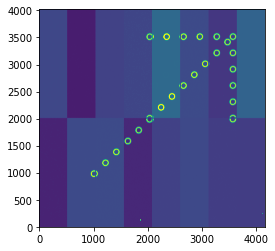

In [7]:
plt.imshow(image,vmax=1200, origin='lower')

In [64]:
amp

In [63]:
ccd = post.getDetector()
amp = ccd.getAmplifiers()[15]
amp.getName()
amp.getRawHorizontalOverscanBBox()

Box2I(minimum=Point2I(0, 0), dimensions=Extent2I(0, 0))

In [66]:
ee = butler.get('raw', dataId)

In [11]:
for amp in ccd:
    print(amp.getName())

C10
C11
C12
C13
C14
C15
C16
C17
C07
C06
C05
C04
C03
C02
C01
C00


In [38]:
amp.getName()

'C00'

In [13]:
amp.getRawHorizontalOverscanBBox()

Box2I(minimum=Point2I(0, 0), dimensions=Extent2I(0, 0))

this corresponds to the following header information:

In [43]:
path_to_raw_phosim = '/project/scichris/repackagerTest/extraRpkgdAmp/'
path_to_file = os.path.join(path_to_raw_phosim, 'MC_H_20000217_000032_R22_S00.fits')
hdul = fits.open(path_to_file)


In [32]:
# phosim BOT-like repackaged file header... 

# [0]: primary DETSIZE = '[1:4096,1:4004]' 
# [16]: C00 amp:  ('AMPID') 
#   DATASEC '[11:522,1:2002]' 
#   DETSEC '[1:512,4004:2003]'
#   NAXIS1    522 
#   NAXIS2    2010 
#   TRIMSEC  '[   4: 512,   1:2000]'
#hdul[0].header

In [35]:
hdul[16].data.shape

(2010, 522)

In [36]:
hdul[16].header['DATASEC']

'[11:522,1:2002]'

In [37]:
hdul[16].header['AMPID']

'C00'

In [46]:

hdul[16].header['TRIMSEC']

'[   4: 512,   1:2000]'

check the header data input by the old phosim repackager... 

In [50]:
import os 
import astropy.io.fits as fits
path_to_raw_phosim = '/project/scichris/repackagerTest/extraRpkgdAmpOLD/'
path_to_file = os.path.join(path_to_raw_phosim, 'lsst_a_9006001_f1_R22_S00_E000.fits')
hdul = fits.open(path_to_file)


In [48]:
# [1]: C00 amp ('AMPID')
# DATASEC '[4:512,1:2000]'
# DETSEC '[509:1,1:2000]'
# NAXIS1 522 
# NAXIS2 2010 
# TRIMSEC [   4: 512,   1:2000] 
hdul[1].header['AMPID']

'C00'

In [51]:
hdul[1].header['TRIMSEC']

'[   4: 512,   1:2000]'

check out what BOT has for that ... Could there the overscan correction be done? Or is it that the lsstCamMapper does not allow overscan correction ? 

In [15]:
import lsst.daf.persistence as dafPersist
repo_dir = "/project/shared/BOT/_parent"
butler = dafPersist.Butler(repo_dir)
data_id={'visit':3020082500032, 'raftName':'R22', 'detectorName':'S00'}
post = butler.get('raw', **data_id)


MC_C_20200825_000032 R22_S00: No FILTER key found but FILTER2="ND_OD1.0" (removed)


In [16]:
ccd = post.getDetector()
for amp in ccd:
    print(amp.getName())

C10
C11
C12
C13
C14
C15
C16
C17
C07
C06
C05
C04
C03
C02
C01
C00


In [30]:
amp.getName()

'C00'

In [17]:
amp.getRawHorizontalOverscanBBox()

Box2I(minimum=Point2I(522, 0), dimensions=Extent2I(54, 2002))

check out which header values these correspond to : 

In [44]:
import os
import astropy.io.fits as fits
path_to_raw_bot = '/project/shared/BOT/_parent/raw/2020-08-25/3020082500032/'
files = os.listdir(path_to_raw_bot)
for file in files:
    if 'R22-S00' in file:
        fname = file
filepath = os.path.join(path_to_raw_bot, fname)
hdul = fits.open(filepath)

In [51]:
amp.getRawHorizontalOverscanBBox??

Docstring: getRawHorizontalOverscanBBox(self: lsst.afw.cameraGeom.amplifier.amplifier.Amplifier) -> lsst.geom.Box2I
Type:      method


Looks like for LsstCam this data is defined in 
https://github.com/lsst/obs_lsst/blob/master/policy/cameraHeader.yaml

In [46]:
# amp C00 has getRawHorizontalOverscanBBox()
# Box2I(minimum=Point2I(522, 0), dimensions=Extent2I(54, 2002))

# [0] (primary):  DETSIZE = '[1:4096,1:4004]'

# [1] (first amp): DATASEC = '[11:522,1:2002]'                                                     
#                  DETSEC  = '[512:1,1:2002]'                                                      
#                  DETSIZE = '[1:4096,1:4004]'
#                  NAXIS1 = 576 
#                  NAXIS2 = 2048 

#  DATASEC '[11:522,1:2002]' 
#   DETSEC '[1:512,4004:2003]'
#   DETSIZE '[1:4096,1:4004]' 


# [16] (amp C00): DATASEC = '[11:522,1:2002]'                                                     
#      DETSEC  = '[512:1,1:2002]'                                                      
#      DETSIZE = '[1:4096,1:4004]' 
#      NAXIS1 = 576 
#      NAXIS2 = 2048 

hdul[1].header

XTENSION= 'IMAGE   '           / marks beginning of new HDU                     
BITPIX  =                   32 / bits per data value                            
NAXIS   =                    2 / number of axis                                 
NAXIS1  =                  576 / size of the n'th axis                          
NAXIS2  =                 2048 / size of the n'th axis                          
PCOUNT  =                    0 / Required value                                 
GCOUNT  =                    1 / Required value                                 
CHECKSUM= 'WA5AY833WA3AW533'   / checksum for the current HDU                   
CHANNEL =                    1                                                  
EXTNAME = 'Segment10'                                                           
CCDSUM  = '1 1     '                                                            
DATASEC = '[11:522,1:2002]'                                                     
DETSEC  = '[512:1,1:2002]'  

Take from baldur the code comparing phosim mapper to lsstCam mapper.. 

In [58]:
from lsst.obs.lsst.phosim import PhosimMapper
from lsst.obs.lsst.lsstCamMapper import LsstCamMapper   
from lsst.obs.lsst import LsstCam

camera = LsstCam().getCamera()
sensorId = 'R22_S00'
detectors = camera.get(sensorId)

# using here same names as raw phosim 
print('*** LsstCam *** ')
for amp in detectors:
    print(amp.getName(), amp.getName(), amp.getRawDataBBox(), amp.getRawFlipX(), amp.getRawFlipY())
    


*** LsstCam *** 
C10 C10 (minimum=(10, 0), maximum=(521, 2001)) True True
C11 C11 (minimum=(10, 0), maximum=(521, 2001)) True True
C12 C12 (minimum=(10, 0), maximum=(521, 2001)) True True
C13 C13 (minimum=(10, 0), maximum=(521, 2001)) True True
C14 C14 (minimum=(10, 0), maximum=(521, 2001)) True True
C15 C15 (minimum=(10, 0), maximum=(521, 2001)) True True
C16 C16 (minimum=(10, 0), maximum=(521, 2001)) True True
C17 C17 (minimum=(10, 0), maximum=(521, 2001)) True True
C07 C07 (minimum=(10, 0), maximum=(521, 2001)) False False
C06 C06 (minimum=(10, 0), maximum=(521, 2001)) False False
C05 C05 (minimum=(10, 0), maximum=(521, 2001)) False False
C04 C04 (minimum=(10, 0), maximum=(521, 2001)) False False
C03 C03 (minimum=(10, 0), maximum=(521, 2001)) False False
C02 C02 (minimum=(10, 0), maximum=(521, 2001)) False False
C01 C01 (minimum=(10, 0), maximum=(521, 2001)) False False
C00 C00 (minimum=(10, 0), maximum=(521, 2001)) False False


In [59]:
detectors.hasCrosstalk()

False

In [63]:
from lsst.obs.lsst import LsstCamPhoSim
ch_map = {'00': '10',
          '01': '11',
          '02': '12',
          '03': '13',
          '04': '14',
          '05': '15',
          '06': '16',
          '07': '17',
          '17': '07',
          '16': '06',
          '15': '05',
          '14': '04',
          '13': '03',
          '12': '02',
          '11': '01',
          '10': '00'}
camera = LsstCamPhoSim().getCamera()
sensorId = 'R22_S00'
detectors = camera.get(sensorId)
print('*** LsstCamPhoSim *** ')
for amp in detectors:
    print('C%s'%ch_map[amp.getName()[1:]], amp.getName(), amp.getRawDataBBox(), amp.getRawFlipX(), amp.getRawFlipY())
   

*** LsstCamPhoSim *** 
C00 C10 (minimum=(3, 0), maximum=(511, 1999)) True False
C01 C11 (minimum=(3, 0), maximum=(511, 1999)) True False
C02 C12 (minimum=(3, 0), maximum=(511, 1999)) True False
C03 C13 (minimum=(3, 0), maximum=(511, 1999)) True False
C04 C14 (minimum=(3, 0), maximum=(511, 1999)) True False
C05 C15 (minimum=(3, 0), maximum=(511, 1999)) True False
C06 C16 (minimum=(3, 0), maximum=(511, 1999)) True False
C07 C17 (minimum=(3, 0), maximum=(511, 1999)) True False
C17 C07 (minimum=(3, 0), maximum=(511, 1999)) True True
C16 C06 (minimum=(3, 0), maximum=(511, 1999)) True True
C15 C05 (minimum=(3, 0), maximum=(511, 1999)) True True
C14 C04 (minimum=(3, 0), maximum=(511, 1999)) True True
C13 C03 (minimum=(3, 0), maximum=(511, 1999)) True True
C12 C02 (minimum=(3, 0), maximum=(511, 1999)) True True
C11 C01 (minimum=(3, 0), maximum=(511, 1999)) True True
C10 C00 (minimum=(3, 0), maximum=(511, 1999)) True True


In [ ]:
amp_info_records1 = list(list(PhosimMapper().camera)[0])
amp_info_records2 = list(list(LsstCamMapper().camera)[0])

detectors = list(LsstCamMapper().camera)
len(detectors)

In [75]:
from lsst.obs.lsst import LsstCam
camera = LsstCam().getCamera()

In [76]:
def noao_section_keyword(bbox, flipx=False, flipy=False):
    """
    Convert bounding boxes into NOAO section keywords.
    Parameters
    ----------
    bbox : lsst.afw.geom.Box2I
        Bounding box.
    flipx : bool
        Flag to indicate that data should be flipped in the x-direction.
    flipy : bool
        Flag to indicate that data should be flipped in the y-direction.
    """
    xmin, xmax = bbox.getMinX()+1, bbox.getMaxX()+1
    ymin, ymax = bbox.getMinY()+1, bbox.getMaxY()+1
    if flipx:
        xmin, xmax = xmax, xmin
    if flipy:
        ymin, ymax = ymax, ymin
    return '[%i:%i,%i:%i]' % (xmin, xmax, ymin, ymax)

In [52]:
#https://stackoverflow.com/questions/12684368/how-to-left-align-a-fixed-width-string
print('**PhosimMapper**') 
print('EXTNAME     DATASEC(RawDataBBox)      DETSEC(BBox)              getMinY    getMaxY')
  
    

for amp in amp_info_records1:
    # hdu.header['DATASEC']
    datasec = noao_section_keyword(amp.getRawDataBBox()) 
    #hdu.header['DETSEC']
    bbox = amp.getBBox()
    detsec = noao_section_keyword(amp.getBBox(), flipx=amp.getRawFlipX(), flipy=amp.getRawFlipY())
    
    segment  = 'Segment%s' % amp.getName()[1:]
    print('{:^10s} {:^25s} {:<25s} {:^10d} {:^10d}  '.format(segment,datasec,detsec,bbox.getMinY(),bbox.getMaxY()))

**PhosimMapper**
EXTNAME     DATASEC(RawDataBBox)      DETSEC(BBox)              getMinY    getMaxY


NameError: name 'amp_info_records1' is not defined

In [78]:
#https://stackoverflow.com/questions/12684368/how-to-left-align-a-fixed-width-string
print('**LsstCamMapper**') 
print('EXTNAME     DATASEC(RawDataBBox)      DETSEC(BBox)              getMinY    getMaxY')
  
for amp in amp_info_records2:
    # hdu.header['DATASEC']
    datasec = noao_section_keyword(amp.getRawDataBBox()) 
    #hdu.header['DETSEC']
    bbox = amp.getBBox()
    detsec = noao_section_keyword(amp.getBBox(), flipx=amp.getRawFlipX(), flipy=amp.getRawFlipY())
    
    segment  = 'Segment%s' % amp.getName()[1:]
    #print('%10s,%15s,%25s, %10d,%10d'%(segment,datasec,detsec,bbox.getMinY(), bbox.getMaxY() ),)
    print('{:^10s} {:^25s} {:<25s} {:^10d} {:^10d}  '.format(segment,datasec,detsec,bbox.getMinY(),bbox.getMaxY()))

**LsstCamMapper**
EXTNAME     DATASEC(RawDataBBox)      DETSEC(BBox)              getMinY    getMaxY
Segment10       [4:512,1:2000]       [509:1,4000:2001]            2000       3999     
Segment11       [4:512,1:2000]       [1018:510,4000:2001]         2000       3999     
Segment12       [4:512,1:2000]       [1527:1019,4000:2001]        2000       3999     
Segment13       [4:512,1:2000]       [2036:1528,4000:2001]        2000       3999     
Segment14       [4:512,1:2000]       [2545:2037,4000:2001]        2000       3999     
Segment15       [4:512,1:2000]       [3054:2546,4000:2001]        2000       3999     
Segment16       [4:512,1:2000]       [3563:3055,4000:2001]        2000       3999     
Segment17       [4:512,1:2000]       [4072:3564,4000:2001]        2000       3999     
Segment07       [4:512,1:2000]       [4072:3564,1:2000]            0         1999     
Segment06       [4:512,1:2000]       [3563:3055,1:2000]            0         1999     
Segment05       [4:512,1:2000

Try manually changing DATASEC and DETSEC in the phosim-BOT-like  repackaged files, to match those in old phosim repackager... Would it work ? 

In [105]:
path_to_old_repackaged = '/project/scichris/repackagerTest/extraRpkgdAmpOLD/'
path_to_new_repackaged = '/project/scichris/repackagerTest/extraRpkgdAmp/'
path_to_updated = '/project/scichris/repackagerTest/extraRpkgdAmpUpdated/'

#files = os.listdir(path_to_new_repackaged)


sensor = 'S00'
new_filepath = os.path.join(path_to_new_repackaged, 'MC_H_20000217_000032_R22_%s.fits'%sensor)
old_filepath = os.path.join(path_to_old_repackaged, 'lsst_a_9006001_f1_R22_%s_E000.fits'%sensor)

hdul_new  = fits.open(new_filepath)
hdul_old = fits.open(old_filepath)


In [80]:
# order in fits header got preserved 
# regardless of name, i.e. 
# hdul_new[5].header['AMPID']  'C14' (original amp name) 
# # corresponds to 
# hdul_old[5].header['AMPID']  'C04' (remapped amp name )

'C14'

In [106]:
hdul_old[16].header['AMPID']

'C10'

In [107]:
hdul_old[16].header['DETSEC']

'[509:1,4000:2001]'

In [108]:
hdul_new[16].header['AMPID']

'C00'

In [109]:
hdul_new[16].header['DETSEC']

'[1:512,1:2002]'

In [86]:
sensor = fits.HDUList(fits.PrimaryHDU())
sensor.append(hdul_new[0]) # the primary HDU 
for i in range(1,len(hdul_new)): # the amps 
    hdu = hdul_new[i]
    hdu.header['DETSEC'] = hdul_old[i].header['DETSEC']
    sensor.append(hdu)

In [89]:
sensor[5].header['DETSEC']

'[2036:1528,1:2000]'